Najprej bomo prevedli celoštevilski linearni program iz navodil v funkcijo `alpha_od(G)`

In [3]:
def alpha_od(G):
    """
    Compute the size of the maximum odd independent set in the graph G.
    """
    from sage.numerical.mip import MixedIntegerLinearProgram
    
    n = G.order()
    V = G.vertices()
    
    # Create the mixed integer linear program
    mip = MixedIntegerLinearProgram(maximization=True)
    
    # Define variables
    x = mip.new_variable(binary=True) # Indicator if vertex v is in the independent set
    y = mip.new_variable(binary=True) # Indicator if vertex v has neighbors in the independent set
    z = mip.new_variable(integer=True) # Counter for the vertex v
    
    # Objective function
    mip.set_objective(mip.sum(x[v] for v in V))
    
    # Constraints
    for u, v in G.edges(labels=False):
        mip.add_constraint(x[u] + x[v] <= 1)
        
    for u in V:
        sum_neighbors = mip.sum(x[v] for v in G.neighbors(u))
        mip.add_constraint(sum_neighbors <= n * y[u])
        mip.add_constraint(y[u] + sum_neighbors == 2*z[u])
    
    # Solve the MIP
    return mip.solve()

Zapisali bomo tudi CLP za določanje najmanjše število barv za krepko liho barvanje grafa $G$.

In [4]:
def chi_so(G):
    """
    Compute the size of the minimum strong odd coloring of the graph G.
    """
    from sage.numerical.mip import MixedIntegerLinearProgram
    
    n = G.order()
    V = G.vertices()
    
    # Create the mixed integer linear program
    mip = MixedIntegerLinearProgram(maximization=False)
    
    # Define variables
    x = mip.new_variable(binary=True) # Indicator if vertex v has color i
    y = mip.new_variable(binary=True) # Indicator if color i is used
    z = mip.new_variable(integer=True) # Counter for vertex v and color i
    w = mip.new_variable(binary=True) # Indicator if color i appears in the neighborhood of vertex v
    
    # Objective function
    mip.set_objective(mip.sum(y[i] for i in range(n))) # n is obvious upper bound on colors
    
    # Constraints
    for v in V:
        mip.add_constraint(mip.sum(x[v, i] for i in range(n)) == 1) # Each vertex gets exactly one color
        
    for u, v in G.edges(labels=False):
        for i in range(n):
            mip.add_constraint(x[u, i] + x[v, i] <= 1) # Adjacent vertices have different colors
            
    for i in range(n):
        mip.add_constraint(mip.sum(x[v, i] for v in V) <= n * y[i]) # If color i is used, y[i] = 1
   
    for v in V:
        for i in range(n):
            sum_neighbors = mip.sum(x[u, i] for u in G.neighbors(v))
            deg = len(G.neighbors(v))
            mip.add_constraint(w[v, i] <= sum_neighbors) # w[v,i] = 0 if color i does not appear in neighborhood of v
            mip.add_constraint(sum_neighbors <= deg * w[v, i]) # w[v,i] = 1 if color i appears in neighborhood of v
            # these two conditions together mean w[v,i] = 1 iff color i appears in neighborhood of v
            mip.add_constraint(w[v, i] + sum_neighbors == 2 * z[v, i]) # Strong odd coloring condition
            mip.add_constraint(z[v, i] >= 0)
    
    # Solve the MIP
    return mip.solve()

Na nekaj grafih preverimo delovanje (samo test)

In [5]:
from sage.all import Graph
from sage.graphs.graph_generators import graphs

P4 = Graph(5)
C4 = Graph([(0,1),(1,2),(2,3),(3,0)])
C5 = Graph([(0,1),(1,2),(2,3),(3,4),(4,0)])

for name, G in [("P4", P4), ("C4", C4), ("C5", C5)]:
    val = alpha_od(G)
    print(name, "alpha_od =", val)

G1 = Graph(5)
G3 = graphs.CompleteBipartiteGraph(2, 3)
for name, G in [("G1", G1), ("G3", G3)]:
    val = chi_so(G)
    print(name, "chi_so =", val)

P4 alpha_od = 5.0
C4 alpha_od = 1.0
C5 alpha_od = 1.0
G1 chi_so = 1.0
G3 chi_so = 3.0


Zapisali bomo tudi funkcijo, ki generira vse grafe dane velikosti $n$ z lastnostjo `alpha_od(G)` = 1.

In [6]:
def generate_graphs_with_alpha_od_equal_to_1(n):
    """
    Iterate over all non-isomorphic graphs with n vertices using nauty_geng and return a set of those graphs G for which alpha_od(G) == 1. It is meant to used for n <= 9.
    """
    from sage.graphs.graph_generators import graphs
    
    matches = list()
    for G in graphs(n):
        if G.diameter() > 2:
            continue  # Neccessary condition for alpha_od(G) == 1 is diameter at most 2
        elif alpha_od(G) == 1:
            matches.append(G)
            
    return matches

# Example usage:
graphs_with_alpha_od_1 = generate_graphs_with_alpha_od_equal_to_1(3)
len(graphs_with_alpha_od_1)
# na mojem računalniku sem potreboval ~40 sekund za n=8

2

We will also need a `is_claw_free(G)` function

In [7]:
def is_claw_free(G):
    """
    Check if the given graph G is claw-free. A graph is claw-free if it does not contain K_{1,3} as an induced subgraph.
    """
    from sage.graphs.graph_generators import graphs
    
    claw = graphs.ClawGraph() # K_{1,3}
    return G.subgraph_search(claw, induced=True) is None # subgraph_search returns None if no such subgraph is found

In [8]:
print(is_claw_free(graphs.CycleGraph(10)))
print(is_claw_free(graphs.PathGraph(7)))
print(is_claw_free(graphs.CompleteGraph(6)))

print(is_claw_free(graphs.StarGraph(4)))
print(is_claw_free(graphs.CompleteBipartiteGraph(3,3)))

True
True
True
False
False


We will also need a function that generates graphs with this `alpha_od(G)` == 1 for  $|V| \geq 10$. We will use a stochastic apporach.

In [9]:
def add_edges_until_diameter_leq_2(G, seed=None):
    """
    Given a graph G, iteratively add edges so that the resulting
    graph H has diameter <= 2.
    
    Process:
    - Compute the diameter path
    - Randomly pick two non-adjacent vertices on that path
    - Add one edge between them
    - Repeat
    
    Returns the modified graph H.
    """
    
    import random
    if seed is not None:
        random.seed(int(seed))

    H = G.copy()
    diameter = H.diameter()

    while diameter > 2:
        # Find all pairs of vertices with distance equal to diameter
        max_distance_pairs = []
        vertices = H.vertices()
        
        for i in range(len(vertices)):
            for j in range(i + 1, len(vertices)):
                u, v = vertices[i], vertices[j]
                if H.distance(u, v) == diameter:
                    max_distance_pairs.append((u, v))
        
        if not max_distance_pairs:
            break
            
        # Pick a random pair at maximum distance
        u, v = random.choice(max_distance_pairs)
        
        # Get the shortest path between them
        path = H.shortest_path(u, v)
        
        # Find non-adjacent vertex pairs in the path
        non_adjacent_pairs = []
        for i in range(len(path)):
            for j in range(i + 2, len(path)):  # i+2 ensures non-adjacent in path
                a, b = path[i], path[j]
                if not H.has_edge(a, b):
                    non_adjacent_pairs.append((a, b))
        
        if not non_adjacent_pairs:
            # Remove this pair and try another
            max_distance_pairs.remove((u, v))
            if max_distance_pairs:
                continue
            else:
                break
        
        # Randomly select a pair to connect
        a, b = random.choice(non_adjacent_pairs)
        
        H.add_edge(a, b)
        print(f"Added edge: ({a}, {b})")
        diameter = H.diameter()
    
    return H

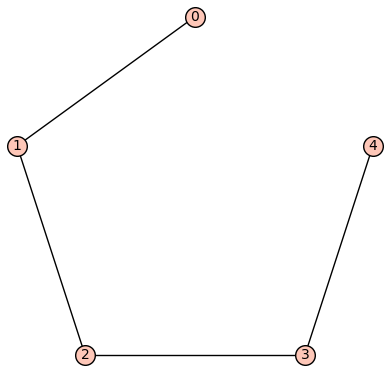

4
Added edge: (0, 2)
Added edge: (1, 3)
Added edge: (0, 3)
2


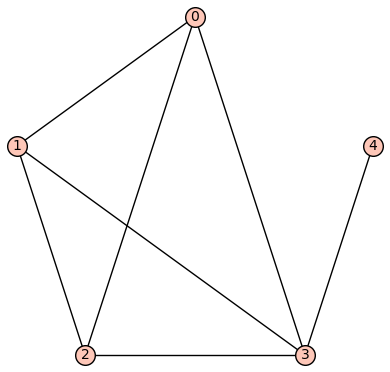

In [10]:
G = graphs.PathGraph(5)
G.show(layout="circular")
print(G.diameter())
H = add_edges_until_diameter_leq_2(G, seed=42)
print(H.diameter())

H.show(layout="circular")

We will use this function to generate random graphs that are candidates for the `alpha_od(G)` = 1.

In [11]:
def generate_large_graphs_with_alpha_od_equal_to_1(n, attempts, seed=None):
    """
    Generate 'count' random graphs with 'n' vertices and diameter <= 2,
    and return those graphs G for which alpha_od(G) == 1.
    """
    import random
    if seed is not None:
        random.seed(int(seed))
    
    matches = list()
    seen_isomorphs = set()
    
    for _ in range(attempts):
        G = graphs.RandomGNP(n, p=0.5, seed=random.randint(0, int(1e6)))
        H = add_edges_until_diameter_leq_2(G, seed=random.randint(0, int(1e6)))
        
        canon_repr = H.canonical_label().graph6_string()
        if canon_repr in seen_isomorphs:
            continue # dont compute alpha_od for already seen graphs
        
        if alpha_od(H) == 1:
            seen_isomorphs.add(canon_repr)
            matches.append(H)
            
    return matches

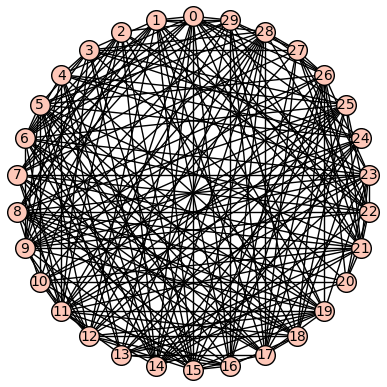

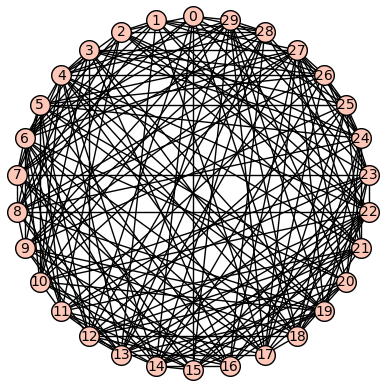

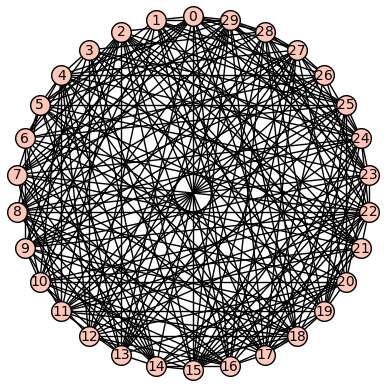

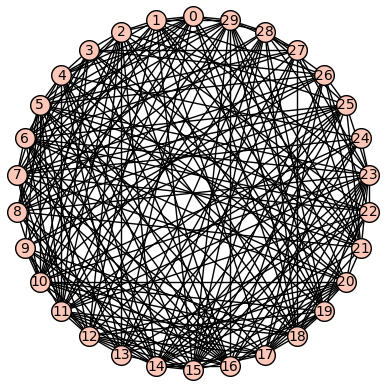

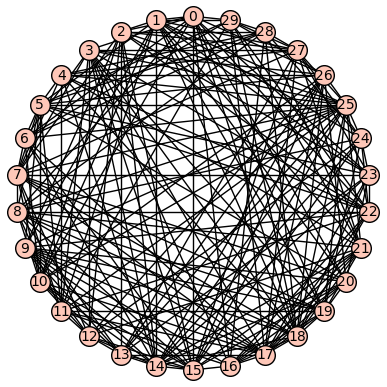

In [13]:
for G in generate_large_graphs_with_alpha_od_equal_to_1(30, 5, seed=123):
    G.show(layout="circular")